In [1]:
import sys
sys.path.append("/kaggle/input/stacknetexample/pystacknet/")
import pystacknet

In [2]:
import gc
import pandas as pd
import numpy as np
from glob import glob
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
true_toxic = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')['toxic'].values

In [3]:
data_dir = '/kaggle/input/prep-stack-data-0622/'
valid = pd.read_pickle(data_dir + 'valid_pred.pkl')
test = pd.read_pickle(data_dir + 'test_pred.pkl')
test = test[valid.columns]

In [4]:
print(valid.shape)
print(test.shape)

(8000, 1909)
(63812, 1909)


In [5]:
assert valid.min().min() >= 0
assert valid.max().max() <= 1
assert test.min().min() >= 0
assert test.max().max() <= 1
pred_list = [col for col in valid.columns if "pred" in col and \
             "train_only" not in col \
             and col in test.columns and \
             "lol_auxcluster_finetune_a1" not in col]

In [6]:
len(pred_list)

1909

In [7]:
import warnings
warnings.simplefilter(action='ignore')

In [8]:
from pystacknet.pystacknet import StackNetRegressor, StackNetClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#PARAMETERS
FOLDS=np.load('/kaggle/input/fork-of-jmt-prep-stratified-5cv/skf_split.npy', allow_pickle=True)
METRIC="auc"
RESTACKING=True # whether we should add previous layer into next layers, if True, add base features to 2nd layer fitting
RETRAIN=False # do not refit the whole model on whole data
USE_PROBA=True
SEED=42
VERBOSE=1

#### for more exotic models like keras customized models, refer to:
# https://github.com/h2oai/pystacknet/blob/master/pystacknet/notebook/StackNetRegressor_Example.ipynb

models=[
    ### each level is a list of models ###
    
    ### 1ST level ###
    [
        ExtraTreesClassifier(**{'max_depth': 18,
                             'max_features': 8,
                             'max_leaf_nodes': 196,
                             'min_samples_leaf': 2,
                             'min_samples_split': 9,
                             'n_estimators': 1000,
                             'criterion': 'entropy',
                             'n_jobs': -1,
                             'random_state': 23}
                            ),
        RandomForestClassifier(**{'max_depth': 10,
                             'max_features': 3,
                             'max_leaf_nodes': 32,
                             'min_samples_leaf': 10,
                             'min_samples_split': 40,
                             'n_estimators': 1000,
                             'criterion': 'entropy',
                             'n_jobs': -1,
                             'random_state': 24}),
        ExtraTreesClassifier(**{'max_depth': 10,
                             'max_features': 4,
                             'max_leaf_nodes': 64,
                             'min_samples_leaf': 20,
                             'min_samples_split': 50,
                             'n_estimators': 1000,
                             'criterion': 'entropy',
                             'n_jobs': -1,
                             'random_state': 25}
                            ),
        RandomForestClassifier(**{'max_depth': 5,
                             'max_features': 4,
                             'max_leaf_nodes': 128,
                             'min_samples_leaf': 30,
                             'min_samples_split': 60,
                             'n_estimators': 1000,
                             'criterion': 'entropy',
                             'n_jobs': -1,
                             'random_state': 26}),
        LGBMClassifier(**{
                        'objective':'binary',
                        'boosting_type':'rf',
                        'metric':'auc',
                        'n_jobs':-1,
                        'learning_rate':0.0001,
                        'num_leaves': 5,
                        'max_depth': 3,
                        'tree_learner':'serial',
                        'colsample_bytree': 0.5,
                        'subsample_freq':1,
                        'subsample': 0.5,
                        'n_estimators': 1000,
                        'max_bin': 255,
                        'verbose': 0,
                        'seed': SEED,
                    }),
        XGBClassifier(**{
                        'n_estimators': 1000,
                        'max_depth': 9,
                        'learning_rate': 0.03,
                        'subsample': 0.77,
                        'colsample_bytree': 0.414,
                        'missing': -999,
                        'random_state': SEED,
                        'eval_metric': 'auc',
                        'reg_alpha': 0.3,
                        'reg_lambda': 0.3,
                        'tree_method':'hist'
                    }),
    ] + [
        LogisticRegression(C=1.0/my_C, l1_ratio=0)
        for my_C in range(1, 11)
    ] + [
        LogisticRegression(C=1.0/my_C, l1_ratio=1.0)
        for my_C in range(1, 11)
    ],
    
        ### 2ND level ###
        [
            ExtraTreesClassifier(**{'max_depth': 18,
                             'max_features': 8,
                             'max_leaf_nodes': 196,
                             'min_samples_leaf': 2,
                             'min_samples_split': 9,
                             'n_estimators': 1935,
                             'criterion': 'entropy',
                             'n_jobs': -1,
                             'random_state': 23}
                            )
        ],

]

#MODEL STATEMENT
model=StackNetClassifier(models, metric=METRIC, folds=FOLDS,
    restacking=RESTACKING, use_retraining=RETRAIN, use_proba=USE_PROBA,
    random_state=SEED, verbose=VERBOSE)

In [9]:
#MODEL FIT
oof = model.fit_oof(valid[pred_list].values, true_toxic)

====================== Start of Level 0 ======================
Input Dimensionality 1909 at Level 0 
26 models included in Level 0 
Fold 1/5 , model 0 , auc===0.953582 
Fold 1/5 , model 1 , auc===0.953543 
Fold 1/5 , model 2 , auc===0.952691 
Fold 1/5 , model 3 , auc===0.953465 
Fold 1/5 , model 4 , auc===0.953813 
Fold 1/5 , model 5 , auc===0.954240 
Fold 1/5 , model 6 , auc===0.949814 
Fold 1/5 , model 7 , auc===0.952138 
Fold 1/5 , model 8 , auc===0.953759 
Fold 1/5 , model 9 , auc===0.953759 
Fold 1/5 , model 10 , auc===0.954294 
Fold 1/5 , model 11 , auc===0.954933 
Fold 1/5 , model 12 , auc===0.954813 
Fold 1/5 , model 13 , auc===0.954903 
Fold 1/5 , model 14 , auc===0.955077 
Fold 1/5 , model 15 , auc===0.955927 
Fold 1/5 , model 16 , auc===0.949814 
Fold 1/5 , model 17 , auc===0.952138 
Fold 1/5 , model 18 , auc===0.953759 
Fold 1/5 , model 19 , auc===0.953759 
Fold 1/5 , model 20 , auc===0.954294 
Fold 1/5 , model 21 , auc===0.954933 
Fold 1/5 , model 22 , auc===0.954813 
Fold

In [10]:
for level in [1, 2]:
    for model_idx in range(len(models[level-1])):
        print("level =", level, "model_idx =", model_idx, roc_auc_score(true_toxic, oof[level-1][:, model_idx]))

level = 1 model_idx = 0 0.960127775576131
level = 1 model_idx = 1 0.9600174130249426
level = 1 model_idx = 2 0.9594468662559595
level = 1 model_idx = 3 0.9598043736715063
level = 1 model_idx = 4 0.9590931416699692
level = 1 model_idx = 5 0.9593401063995869
level = 1 model_idx = 6 0.9544851148659197
level = 1 model_idx = 7 0.957217038344682
level = 1 model_idx = 8 0.958246568433188
level = 1 model_idx = 9 0.9590295541064717
level = 1 model_idx = 10 0.9593088830445172
level = 1 model_idx = 11 0.959795366934467
level = 1 model_idx = 12 0.9599388742779598
level = 1 model_idx = 13 0.960284612890442
level = 1 model_idx = 14 0.9603522234631504
level = 1 model_idx = 15 0.9606574918038693
level = 1 model_idx = 16 0.9544851148659197
level = 1 model_idx = 17 0.957217038344682
level = 1 model_idx = 18 0.958246568433188
level = 1 model_idx = 19 0.9590295541064717
level = 1 model_idx = 20 0.9593088830445172
level = 1 model_idx = 21 0.959795366934467
level = 1 model_idx = 22 0.9599388742779598
level 

In [11]:
%%time
test_pred = model.predict_proba(test[pred_list].values)[:, 1]

====================== Start of Level 0 ======================
5 estimators included in Level 0 
====================== Start of Level 1 ======================
5 estimators included in Level 1 
CPU times: user 9min 38s, sys: 17.9 s, total: 9min 56s
Wall time: 3min 27s


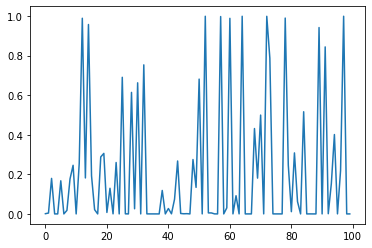

In [12]:
pd.Series(test_pred).iloc[:100].plot()

In [13]:
sub['toxic'] = test_pred
sub.to_csv("submission.csv", index=False)

In [14]:
val_orig = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
val_orig['pred'] = oof[-1]
val_orig.to_csv("valid_pred.csv", index=False)

test_orig = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test_orig['pred'] = test_pred
test_orig.to_csv("test_pred.csv", index=False)